# Random Useless Facts API

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iragca/pit-predictive-analysis/blob/master/notebooks/1.0-random-useless-facts.ipynb)





## **Executive Summary**

This research explores the semantic structure of thousands of public trivia statements—commonly known as “useless facts”—retrieved from the Random Useless Facts API. Although these facts are informal and often humorous, they represent a rich and diverse corpus of short natural-language statements. By applying two major unsupervised topic modeling methods, Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF), the study examines whether the seemingly chaotic collection of trivia exhibits coherent underlying themes.

A complete computational pipeline is developed, encompassing data collection, text preprocessing, feature extraction, model training, topic evaluation, and visualization. The pipeline identifies recurring themes embedded in the trivia corpus, such as biological phenomena, animal-related oddities, historical anecdotes, linguistic curiosities, and surprising scientific facts. Beyond analyzing trivia, the project demonstrates how modern topic modeling can effectively uncover structure within unstructured, non-technical, and multilingual text sources. The resulting framework provides a repeatable method for analyzing similar short-form text datasets.

## **Table of Contents**

```bash
.
├── Title Section
│       ├── Executive Summary
│       ├── Table of Contents                   #  ⭐ You are here
│       └── Setup                               #  Libraries and dataset imports
├── Introduction
│       ├── Problem Statement
└── Methodology
│       ├── API Wrapper
│       ├── Data Warehousing
│       ├── Data Ingesting 
│       ├── Data Exploration
│       ├── Data Preprocessing
│       ├── Data Modelling
```


## **Setup**

Before running this notebook make sure to have environment variables set: `SUPABASE_URL` and `SUPABASE_KEY`.


In [1]:
import subprocess

from tqdm import tqdm


try:
    import google.colab  # type: ignore
    IS_COLAB_ENVIRONMENT = True
except ImportError:
    IS_COLAB_ENVIRONMENT = False

if IS_COLAB_ENVIRONMENT:
    from google.colab import userdata # type: ignore
    DEPENDENCIES = [
        "bertopic", 
        "gensim"
        "iragca",
        "pydantic",
        "sentence-transformers", 
        "supabase", 
        "umap-learn",
    ]
    def install(package: str) -> None:
        subprocess.run(
            ["pip", "install", package],
            stdout=subprocess.DEVNULL
        )
    pbar = tqdm(DEPENDENCIES, desc="Installing dependencies")
    for package in pbar:
        pbar.set_description(f"Installing '{package}'")
        install(package)

In [48]:
from enum import Enum
from functools import lru_cache
from itertools import batched, chain
import os
import random
from time import sleep as cooldown
from typing import Optional
from urllib.parse import urlencode, urljoin
import warnings


import dotenv
import httpx
import numpy as np
from iragca.matplotlib import Styles, Color
import matplotlib.pyplot as plt
from pydantic import BaseModel
import seaborn as sns
from supabase import Client, create_client

dotenv.load_dotenv()
plt.style.use(Styles.ML.value)
warnings.filterwarnings("ignore")

# **Introduction**

“Useless facts” are pieces of trivia or curious fragments of information that are often surprising, entertaining, or obscure, yet rarely practical in daily life. Despite their seemingly trivial nature, these factoids circulate widely across digital platforms—particularly on social media, blogs, online forums, and dedicated trivia websites—where they captivate audiences by appealing to people’s natural curiosity and fascination with unexpected knowledge. The Random Useless Facts API serves as a public web service that aggregates thousands of these items, enabling programmatic access to randomly selected facts in multiple languages, including English and German. Each retrieved entry typically contains the text of the fact itself, a unique identifier, metadata regarding its original source, and a stable permalink for reference. The structured yet diverse nature of this content creates an opportunity for systematic computational analysis.

This study investigates the underlying semantic patterns present within a large collection of such “useless facts” through the use of topic modeling, a class of unsupervised machine learning methods designed to identify latent themes in textual data. Topic modeling algorithms group documents—here, individual fact statements—based on shared vocabulary and co-occurrence patterns, allowing researchers to uncover meaningful clusters without requiring manually annotated categories. To explore the thematic composition of the dataset, we implement and compare two widely used topic modeling approaches: Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF). These models provide complementary perspectives on the structure of the corpus, revealing which recurring subjects—such as animals, historical events, linguistic oddities, biological phenomena, or everyday objects—are most prevalent within the collection.

To conduct this analysis, a complete machine learning pipeline is developed, covering all essential stages of text-based research. This pipeline begins with programmatically retrieving data from the API, followed by cleaning, preprocessing, and normalizing the text to ensure suitability for quantitative analysis. The next phase involves transforming the processed text into numerical feature representations using vectorization techniques such as TF-IDF and Bag-of-Words. These representations serve as inputs to the LDA and NMF models, which are then trained, tuned, and evaluated to determine the most coherent and interpretable topic structures. Finally, the identified topics are visualized, interpreted, and examined for linguistic and thematic insights. This end-to-end workflow ensures methodological rigor, reproducibility, and scalability, establishing a robust framework that can readily be adapted for analyzing similar text-rich datasets.

## **Problem Statement**

Trivia content labeled as “useless facts” is characterized by its randomness, brevity, and lack of practical application. At first glance, these statements appear disconnected and purely humorous. However, when collected in large quantities, they may contain underlying patterns or recurring themes that are not immediately obvious. Despite their mundaneness, such facts could still reflect shared human interests, common cultural references, or frequently occurring knowledge domains.

This leads to the central problem guiding this study:

**What are the most common topics being observed despite the mundaneness of the subject matter?**

Addressing this question presents several methodological challenges:

1. Lack of inherent structure — “Useless facts” are not categorized by subject, making thematic grouping non-trivial.

2. Short and noisy text format — Each fact is typically only one or two sentences long, limiting contextual information that topic modeling methods rely on.

3. Semantic diversity — The corpus contains a wide range of content (biology, history, humor, linguistics, science, etc.), but without any explicit labeling.

4. Multilingual nature — The inclusion of multiple languages (e.g., English and German) introduces linguistic variability that complicates preprocessing and modeling.

5. Absence of ground-truth categories — Because there is no predefined taxonomy of “useless facts,” fully unsupervised methods are required to identify meaningful patterns.

Given these challenges, the aim is to determine whether coherent themes can still emerge from such random and seemingly trivial content. Through topic modeling techniques such as Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF), this study seeks to uncover the dominant themes present within the corpus, revealing the types of subjects people inadvertently encode into what is commonly perceived as insignificant information.

# **Methodology**

[![](https://mermaid.ink/img/pako:eNpVkU9rwkAQxb_KMoeeoiRuTHQPBesfKFQoRXpo4mFJxriQ7KaT3dYqfvcmEQnuad_83pt3mAtkJkcQcCjNb3aUZNnbR6pZ-xbJSlrJFtm3U42yyug9u5HR6Jm9JDs8WfZOWJPJsGmULvYDXiYblNYRsrUulEakR75KdqZWGdu27eUjWif9kK1_ZOlk3zvATfKpGidLde4Je2Kv2iLVhPZuBQ8KUjkISw49qJAq2Um4dGtSsEesMAXRfnM8SFfaFFJ9bWO11F_GVPckGVccQRxk2bTK1bm0uFKyIDlYUOdIS-O0BRFM-hUgLnACMfGDcRQHM-5PoyjmMece_LUmfz7uRDDnnMfhNAqvHpz7Vn88D-IoCMNZi3nEuwTmyhra3m7Un-r6D6NqiAI?type=png)](https://mermaid.live/edit#pako:eNpVkU9rwkAQxb_KMoeeoiRuTHQPBesfKFQoRXpo4mFJxriQ7KaT3dYqfvcmEQnuad_83pt3mAtkJkcQcCjNb3aUZNnbR6pZ-xbJSlrJFtm3U42yyug9u5HR6Jm9JDs8WfZOWJPJsGmULvYDXiYblNYRsrUulEakR75KdqZWGdu27eUjWif9kK1_ZOlk3zvATfKpGidLde4Je2Kv2iLVhPZuBQ8KUjkISw49qJAq2Um4dGtSsEesMAXRfnM8SFfaFFJ9bWO11F_GVPckGVccQRxk2bTK1bm0uFKyIDlYUOdIS-O0BRFM-hUgLnACMfGDcRQHM-5PoyjmMece_LUmfz7uRDDnnMfhNAqvHpz7Vn88D-IoCMNZi3nEuwTmyhra3m7Un-r6D6NqiAI)

## **API Wrapper**

In [3]:
class Language(str, Enum):
    """
    Enumeration of supported languages for the Random Useless Facts API.

    Each enum member corresponds to the language code expected by the
    remote API.
    """
    ENGLISH = "en"
    GERMAN = "de"

class Fact(BaseModel):
    """
    Data model representing a response returned by the Random Useless Facts API.

    Parameters
    ----------
    id : str
        Unique identifier of the fact.
    text : str
        The textual content of the fact.
    source : str
        Origin or reference for the fact.
    source_url : str
        URL pointing to the source.
    language : Language
        Language in which the fact is written.
    permalink : str
        Permanent URL for accessing the fact.

    Notes
    -----
    This model is parsed from JSON using Pydantic and ensures type validation
    of the incoming API response.
    """
    id: str
    text: str
    source: str
    source_url: str
    language: Language
    permalink: str

    def __hash__(self) -> int:
        return hash(self.id)


class RandomUselessFactAPI:
    """
    Client for interacting with the Random Useless Facts API.

    Parameters
    ----------
    base_url : str, optional
        Base URL of the API. Defaults to ``"https://uselessfacts.jsph.pl/"``.

    Notes
    -----
    This class exposes convenience methods to construct API URLs and retrieve
    random facts in various languages. Requests are executed using ``httpx``.
    """
    def __init__(self, base_url: str ="https://uselessfacts.jsph.pl/") -> None:
        self.base_url = base_url

    def get_random_fact(self, language: Language = Language.ENGLISH) -> Fact:
        """
        Retrieve a random useless fact.

        Parameters
        ----------
        language : Language, optional
            Language in which the fact should be returned. Defaults to
            ``Language.ENGLISH``.

        Returns
        -------
        Response
            Parsed API response containing the random fact.

        Raises
        ------
        httpx.HTTPError
            If the request fails or returns an error status code.

        Examples
        --------
        >>> api = RandomUselessFactAPI()
        >>> fact = api.get_random_fact()
        >>> fact.text
        'Banging your head against a wall for one hour burns 150 calories.'
        """
        url = self._build_random_fact_url(language)
        response = httpx.get(url)
        response.raise_for_status()
        data = response.json()

        return Fact(**data)
    
    def _build_random_fact_url(self, language: Optional[Language] = None) -> str:
        """
        Construct the request URL for fetching a random fact.

        Parameters
        ----------
        language : Optional[Language], optional
            Language code to include as a query parameter. Defaults to
            ``None``.

        Returns
        -------
        str
            Fully constructed URL pointing to the random fact endpoint.

        Notes
        -----
        This method is internal and is not intended to be called directly by
        users. It performs safe URL joining and query parameter encoding.
        """
        ENDPOINT = "api/v2/facts/random"
        path = urljoin(self.base_url, ENDPOINT)
        
        if language is not None:
            params = urlencode({"language": language.value})
            return f"{path}?{params}"
        return path
    

## **Data Warehouse**

In [4]:
class SupabaseStorage:
    """
    Storage interface for interacting with the Supabase `facts` table.

    This class handles:
    - Environment variable loading for Supabase credentials
    - Inserting single or multiple facts into the database
    - Retrieving all stored facts

    Attributes
    ----------
    supabase : supabase.Client
        Initialized Supabase client used for database operations.

    Raises
    ------
    ValueError
        If required Supabase environment variables are missing.
    """
    def __init__(self) -> None:
        """
        Initialize the Supabase client using environment variables.

        The method attempts to load the Supabase URL and API key using
        `load_env`. If either value is missing, an exception is raised.

        Raises
        ------
        ValueError
            If `SUPABASE_URL` or `SUPABASE_KEY` is not set.
        """
        env = self.load_env()
        if env and all(env.values()):
            self.supabase: Client = create_client(env["url"], env["key"])
        else:
            raise ValueError("SUPABASE_URL and SUPABASE_KEY must be set in environment variables.")

    @lru_cache
    def insert_fact(self, fact: Fact):
        """
        Insert a single fact into the Supabase `facts` table.

        This method is cached with an LRU cache of size 1.

        Parameters
        ----------
        fact : Fact
            The fact object to be inserted into the database.

        Returns
        -------
        supabase.lib.client_response.ClientResponse
            Response object returned by the Supabase insert operation.
        """
        response = self.supabase.table("facts").insert(fact.model_dump()).execute()
        return response

    def insert_facts(self, facts: list[Fact]):
        """
        Insert multiple facts into the Supabase `facts` table.

        Parameters
        ----------
        facts : list of Fact
            A list of fact objects to be inserted.

        Returns
        -------
        supabase.lib.client_response.ClientResponse
            Response object returned by the Supabase bulk insert operation.
        """
        response = self.supabase.table("facts").insert([fact.model_dump() for fact in facts]).execute()
        return response

    def get_all_facts(self) -> list[Fact]:
        """
        Retrieve all facts from the Supabase `facts` table.

        Returns
        -------
        list of Fact
            A list of `Fact` objects reconstructed from the database records.
        """
        response = self.supabase.table("facts").select("*").execute()
        data = response.data
        return [Fact(**item) for item in data]

    def get_english_facts(self) -> list[Fact]:
        """
        Retrieve only English facts from the Supabase `facts` table.

        Returns
        -------
        list of Fact
            A list of `Fact` objects reconstructed from the database records
            where the language is English.
        """
        response = self.supabase.table("facts").select("*").eq("language", Language.ENGLISH.value).execute()
        data = response.data
        return [Fact(**item) for item in data]

    @staticmethod
    def load_env():
        """
        Load Supabase environment variables.

        This method supports both Google Colab and standard local
        environment variable loading.

        Returns
        -------
        dict
            Dictionary containing:
            - `"url"` : str
                Supabase project URL.
            - `"key"` : str
                Supabase API key.
        """
        if IS_COLAB_ENVIRONMENT:
            url: str = userdata.get("SUPABASE_URL")
            key: str = userdata.get("SUPABASE_KEY")
        else:
            url: str = os.environ.get("SUPABASE_URL", "")
            key: str = os.environ.get("SUPABASE_KEY", "")
        return {"url": url, "key": key}

## **Ingesting Data**

In [12]:
api = RandomUselessFactAPI()
storage = SupabaseStorage()

In [13]:
fact: Fact = api.get_random_fact(language=Language.ENGLISH)
print(fact.text)

The average lead pencil will draw a line 35 miles long or write approximately 50,000 English words.


In [12]:
fact

Fact(id='4de0e54a11c3cd1a0fcfa8275c0e4daa', text='It costs more to buy a new car today in the United States than it cost Christopher Columbus to equip and undertake three voyages to and from the New World.', source='djtech.net', source_url='http://www.djtech.net/humor/useless_facts.htm', language=<Language.ENGLISH: 'en'>, permalink='https://uselessfacts.jsph.pl/api/v2/facts/4de0e54a11c3cd1a0fcfa8275c0e4daa')

In [ ]:
FETCH_COUNT = 100
BATCH_SIZE = 10


def fetch_facts(count: int, cooldown_sec: int = 1) -> list[Fact]:
    facts = []
    for _ in tqdm(range(count), desc="Fetching facts"):
        fact = api.get_random_fact(language=Language.ENGLISH) #Parse facts only in English
        facts.append(fact)
        cooldown(cooldown_sec)  # To avoid hitting rate limits
    return facts

# Fetch facts from the API
facts = fetch_facts(FETCH_COUNT)

failed_batches = []

# Insert facts into Supabase in batches
for batch in tqdm(batched(facts, BATCH_SIZE), total=FETCH_COUNT / BATCH_SIZE, desc="Batch ingest"):
    try:
        storage.insert_facts(list(batch))
    except Exception as e:
        failed_batches.append(list(batch))


errors = []

# Retry failed inserts individually
if failed_batches:
    failed_batches = chain.from_iterable(failed_batches)
    for fact in tqdm(failed_batches, desc="Retrying failed inserts"):
        try:
            storage.insert_fact(fact)
        except Exception as e:
            errors.append((fact, str(e)))

# Analyze errors for duplicates
duplicate_count = sum(1 for fact, error in errors if "duplicate" in error.lower())
duplicate_count

Fetching facts: 100%|██████████| 100/100 [03:03<00:00,  1.84s/it]
Batch ingest: 100%|██████████| 10/10.0 [00:02<00:00,  4.79it/s]
Retrying failed inserts: 100it [00:14,  6.67it/s]


100

## **Data Exploration**

In [14]:
facts = storage.get_all_facts()
len(facts)

1501

In [15]:
facts

[Fact(id='a79df1c3d4ee87fa1c6ffb798cb6c3d1', text='Approximately every seven minutes of every day, someone in an aerobics class pulls their hamstring.', source='djtech.net', source_url='http://www.djtech.net/humor/useless_facts.htm', language=<Language.ENGLISH: 'en'>, permalink='https://uselessfacts.jsph.pl/api/v2/facts/a79df1c3d4ee87fa1c6ffb798cb6c3d1'),
 Fact(id='9930af0979d0b01ffa1311000e6cf29c', text='The country code for Russia is "007".', source='djtech.net', source_url='https://www.djtech.net/humor/shorty_useless_facts.htm', language=<Language.ENGLISH: 'en'>, permalink='https://uselessfacts.jsph.pl/api/v2/facts/9930af0979d0b01ffa1311000e6cf29c'),
 Fact(id='38583dc74ede6858ca400242b81efd8d', text='Steely Dan got their name from a sexual device depicted in the book `The Naked Lunch`. \xa0', source='djtech.net', source_url='http://www.djtech.net/humor/useless_facts.htm', language=<Language.ENGLISH: 'en'>, permalink='https://uselessfacts.jsph.pl/api/v2/facts/38583dc74ede6858ca400242

In [16]:
english_facts = storage.get_english_facts()
print(f"Number of English facts: {len(english_facts)}")

Number of English facts: 1001


In [17]:
english_fact_texts = [fact.text for fact in english_facts]

print(f"Total number of English fact texts extracted: {len(english_fact_texts)}")
print("\nFirst 5 extracted fact texts:")
for i, text in enumerate(english_fact_texts[:5]):
    print(f"{text}")

Total number of English fact texts extracted: 1001

First 5 extracted fact texts:
Approximately every seven minutes of every day, someone in an aerobics class pulls their hamstring.
The country code for Russia is "007".
Steely Dan got their name from a sexual device depicted in the book `The Naked Lunch`.  
Human thigh bones are stronger than concrete.
Starfish have no brains.


## **Text Processing**

In [18]:
import pandas as pd

import nltk
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import contractions

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import LdaModel
from sklearn.decomposition import LatentDirichletAllocation

import warnings
warnings.filterwarnings("ignore")

In [19]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /home/iragca/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/iragca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/iragca/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
def preprocess_text(corpus):
  corpus = re.sub(r'[^a-zA-Z\s]', '', corpus.lower())
  tokens = word_tokenize(corpus)
  sw = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in sw and len(word) > 2]
  stem = WordNetLemmatizer()
  tokens = [stem.lemmatize(word) for word in tokens]
  tokens = [contractions.fix(word) for word in tokens]

  return ' '.join(tokens)

In [21]:
pp_text_eng = [preprocess_text(doc) for doc in english_fact_texts]
pp_text_eng[0:5]

['approximately every seven minute every day someone aerobics class pull hamstring',
 'country code russia',
 'steely dan got name sexual device depicted book naked lunch',
 'human thigh bone stronger concrete',
 'starfish brain']

## **Model**

In [24]:
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

### **Latent Dirchlet Allocation (LDA) Using Sklearn**

In [25]:
cv = CountVectorizer(max_features=128, stop_words='english')
doc_term_matrix = cv.fit_transform(pp_text_eng)

#We can explore 128 out of the 1001 english facts
#We need a reason why but we can narrow down what topics
#Topics that ae quite common but will be reducefd further to the LDA

feature_names = cv.get_feature_names_out()

In [26]:
lda = LatentDirichletAllocation(
    n_components = 4, #number of topics to allocate
    random_state=RANDOM_STATE, #for reproducibility
    max_iter = 28
)

lda.fit(doc_term_matrix)

,"n_components n_components: int, default=10Number of topics... versionchanged:: 0.19 ``n_topics`` was renamed to ``n_components``",4
,"doc_topic_prior doc_topic_prior: float, default=NonePrior of document topic distribution `theta`. If the value is None,defaults to `1 / n_components`.In [1]_, this is called `alpha`.",None
,"topic_word_prior topic_word_prior: float, default=NonePrior of topic word distribution `beta`. If the value is None, defaultsto `1 / n_components`.In [1]_, this is called `eta`.",None
,"learning_method learning_method: {'batch', 'online'}, default='batch'Method used to update `_component`. Only used in :meth:`fit` method.In general, if the data size is large, the online update will be muchfaster than the batch update.Valid options:- 'batch': Batch variational Bayes method. Use all training data in each EM update. Old `components_` will be overwritten in each iteration.- 'online': Online variational Bayes method. In each EM update, use mini-batch of training data to update the ``components_`` variable incrementally. The learning rate is controlled by the ``learning_decay`` and the ``learning_offset`` parameters... versionchanged:: 0.20 The default learning method is now ``""batch""``.",'batch'
,"learning_decay learning_decay: float, default=0.7It is a parameter that control learning rate in the online learningmethod. The value should be set between (0.5, 1.0] to guaranteeasymptotic convergence. When the value is 0.0 and batch_size is``n_samples``, the update method is same as batch learning. In theliterature, this is called kappa.",0.7
,"learning_offset learning_offset: float, default=10.0A (positive) parameter that downweights early iterations in onlinelearning. It should be greater than 1.0. In the literature, this iscalled tau_0.",10.0
,"max_iter max_iter: int, default=10The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the :meth:`fit` method, and not the:meth:`partial_fit` method.",28
,"batch_size batch_size: int, default=128Number of documents to use in each EM iteration. Only used in onlinelearning.",128
,"evaluate_every evaluate_every: int, default=-1How often to evaluate perplexity. Only used in `fit` method.set it to 0 or negative number to not evaluate perplexity intraining at all. Evaluating perplexity can help you check convergencein training process, but it will also increase total training time.Evaluating perplexity in every iteration might increase training timeup to two-fold.",-1
,"total_samples total_samples: int, default=1e6Total number of documents. Only used in the :meth:`partial_fit` method.",1000000.0
,"perp_tol perp_tol: float, default=1e-1Perplexity tolerance. Only used when ``evaluate_every`` is greater than 0.",0.1


In [27]:
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-5:][::-1]  # Get top 5 words
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: world, word, english, eye, letter
Topic 2: human, american, people, average, city
Topic 3: year, state, people, average, person
Topic 4: time, day, mile, year, average


In [28]:
pp_text_eng_lda = lda.transform(doc_term_matrix)
df_lda = pd.DataFrame(
    pp_text_eng_lda.round(3),
    columns=[f'Topic {i+1}' for i in range(4)],
    index=[f'Doc {i+1}' for i in range(len(pp_text_eng))]
)
df_lda.T

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,...,Doc 992,Doc 993,Doc 994,Doc 995,Doc 996,Doc 997,Doc 998,Doc 999,Doc 1000,Doc 1001
Topic 1,0.063,0.625,0.625,0.413,0.125,0.25,0.083,0.125,0.25,0.25,...,0.063,0.125,0.25,0.125,0.125,0.063,0.130,0.063,0.087,0.063
Topic 2,0.063,0.125,0.125,0.418,0.625,0.25,0.083,0.128,0.25,0.25,...,0.063,0.132,0.25,0.613,0.125,0.063,0.125,0.064,0.412,0.811
Topic 3,0.063,0.125,0.125,0.086,0.125,0.25,0.750,0.622,0.25,0.25,...,0.063,0.125,0.25,0.137,0.125,0.063,0.125,0.809,0.083,0.064
Topic 4,0.812,0.125,0.125,0.083,0.125,0.25,0.083,0.125,0.25,0.25,...,0.812,0.618,0.25,0.125,0.625,0.812,0.620,0.065,0.417,0.063


(0.0, 0.31045454545454537)

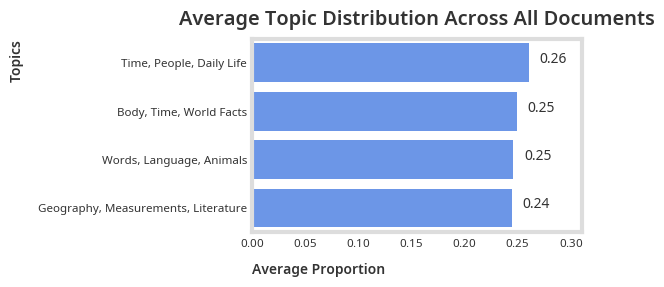

In [57]:

# Calculate average topic proportions across all documents
average_topic_proportions = df_lda.mean()

# Define new topic names based on top words
new_topic_names = {
    'Topic 1': 'Words, Language, Animals',
    'Topic 2': 'Time, People, Daily Life',
    'Topic 3': 'Geography, Measurements, Literature',
    'Topic 4': 'Body, Time, World Facts'
}

# Map the new names to the average_topic_proportions index
# Using .copy() to avoid SettingWithCopyWarning if average_topic_proportions was a slice
pie_data = average_topic_proportions.rename(index=new_topic_names).copy().sort_values(ascending=False)

sns.barplot(
    y=pie_data.index,
    x=pie_data.values,
    orient='h',
)

for i, v in enumerate(pie_data.values):
    plt.text(v + 0.01 , i, f"{v:.2f}", color=Color.SOFT_BLACK.value, ha='left')
plt.xlabel('Average Proportion')
plt.ylabel('Topics')
plt.title('Average Topic Distribution Across All Documents')
plt.xlim(0, max(pie_data.values) + 0.05)

### **Using BERTTopic**

In [31]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

In [32]:
embedding_model = SentenceTransformer("all-mpnet-base-v2") # Will take some time

model = BERTopic(embedding_model=embedding_model)

In [34]:
topics, probabilities = model.fit_transform(pp_text_eng)
print(f"BERTopic model fitted. Number of topics found: {len(model.get_topics())}")

AcceleratorError: CUDA error: no kernel image is available for execution on the device
Search for `cudaErrorNoKernelImageForDevice' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [56]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,372,-1_every_world_year_one,"[every, world, year, one, state, name, mile, p...","[approximately one chicken every human world, ..."
1,0,77,0_name_invented_named_first,"[name, invented, named, first, disney, john, s...","[name wendy made book peter pan, unusual canno..."
2,1,60,1_tongue_muscle_body_water,"[tongue, muscle, body, water, fish, print, str...","[strongest muscle relative size body tongue, r..."
3,2,51,2_word_english_language_letter,"[word, english, language, letter, longest, sen...","[word english language rhyme month, word engli..."
4,3,49,3_average_calorie_eat_celery,"[average, calorie, eat, celery, american, day,...","[every time lick stamp consume calorie, americ..."
5,4,45,4_peanut_ketchup_tree_cocacola,"[peanut, ketchup, tree, cocacola, apple, almon...",[half food eaten throughout world today develo...
6,5,39,5_city_state_largest_mile,"[city, state, largest, mile, country, maine, d...","[maine state whose name one syllable, columbia..."
7,6,31,6_people_year_live_handed,"[people, year, live, handed, billion, populati...",[righthanded people live average nine year lon...
8,7,29,7_bone_foot_growing_faster,"[bone, foot, growing, faster, never, grow, sto...",[eye always size birth nose ear never stop gro...
9,8,22,8_crash_killed_people_died,"[crash, killed, people, died, horse, year, eve...","[people killed annually donkey airplane crash,..."


In [57]:
model.visualize_topics()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0, 'name | invented | named | first | disney', 77],
                                   [1, 'tongue | muscle | body | water | fish', 60],
                                   [2, 'word | english | language | letter | longest', 51],
                                   [3, 'average | calorie | eat | celery | american', 49],
                                   [4, 'peanut | ketchup | tree | cocacola | apple', 45],
                                   [5, 'city | state | largest | mile | country', 39],
                                   [6, 'people | year | live | handed | billion', 31],
                                   [7, 'bone | foot | growing | faster | never', 29],
                                   [8, 'crash | killed | people | died | horse', 22],
                                   [9, 'france | cheese | world | caput | czech', 21],
                                   [10, 'money | dollar | paper | bill | fiction', 19],
                                   [11, 'eye | camel | eyelid | sand | ostrich', 19],
                                   [12, 'sneeze | heart | pressure | creates | squirt', 16],
                                   [13, 'building | empire | step | state | floor', 15],
                                   [14, 'illegal | law | sunday | utah | maverick', 14],
                                   [15, 'sold | capone | business | dealer | prisoner', 14],
                                   [16, 'song | rock | springsteens | pressed | theme', 14],
                                   [17, 'albania | dial | russia | kgb | code', 13],
                                   [18, 'fear | mean | spider | morbid | friday', 12],
                                   [19, 'cow | milk | downstairs | lead | supply', 12],
                                   [20, 'fly | bat | cannot | turn | backwards', 12],
                                   [21, 'hitler | ramses | ancient | napoleon | fathered', 12],
                                   [22, 'planet | earth | orbit | venus | thrown', 11],
                                   [23, 'mcdonalds | restaurant | canada | first | checkout', 11],
                                   [24, 'brain | human | amount | floor | cat', 11]], dtype=object),
              'hovertemplate': '<b>Topic %{customdata[0]}</b><br>%{customdata[1]}<br>Size: %{customdata[2]}',
              'legendgroup': '',
              'marker': {'color': '#B0BEC5',
                         'line': {'color': 'DarkSlateGrey', 'width': 2},
                         'size': {'bdata': 'TTwzMS0nHx0WFRMTEA8ODg4NDAwMDAsLCw==', 'dtype': 'i1'},
                         'sizemode': 'area',
                         'sizeref': 0.048125,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': {'bdata': ('569sQD6HfMAcYW/A3MtDv2vUFUF500' ... 'F95YrA7q2IQPvQhsB59RlBl7KDvw=='),
                    'dtype': 'f4'},
              'xaxis': 'x',
              'y': {'bdata': ('sSvEQI2aSUBJ5idAQcrlwG82WUEc8t' ... 'FYC3BAIAWyQDxZg0AYV11Boi/uwA=='),
                    'dtype': 'f4'},
              'yaxis': 'y'}],
    'layout': {'annotations': [{'showarrow': False,
                                'text': 'D1',
                                'x': -4.991590762138367,
                                'y': 3.6745079278945925,
                                'yshift': 10},
                               {'showarrow': False,
                                'text': 'D2',
                                'x': 4.6278280377388,
                                'xshift': 10,
                                'y': 15.908827590942384}],
               'height': 650,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'legend': {'itemsizing': 'constant', 'tracegroupgap': 0},
               'margin': {'t': 60},
         

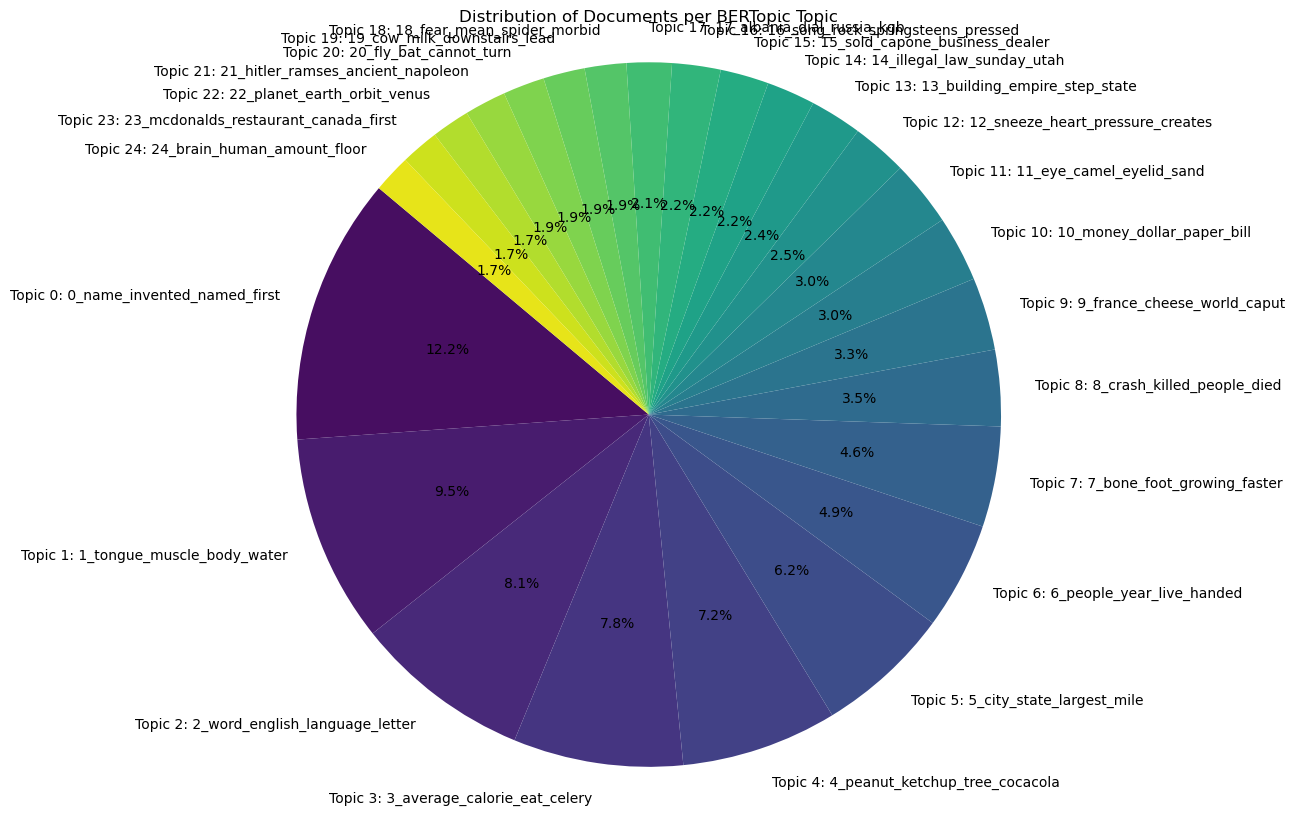

In [60]:
# Get topic information and count documents per topic
topic_counts = model.get_topic_info()
# Filter out the -1 topic (outliers) if needed, or keep it
topic_counts = topic_counts[topic_counts['Topic'] != -1].copy()
topic_counts['Count'] = topic_counts['Count'].astype(int)

# Prepare data for pie chart
pie_labels = [f"Topic {row.Topic}: {row.Name}" for idx, row in topic_counts.iterrows()]
pie_values = topic_counts['Count'].values

plt.figure(figsize=(10, 10))
plt.pie(
    pie_values,
    labels=pie_labels,
    autopct='%1.1f%%', # Format percentage display
    startangle=140,
    colors=sns.color_palette('viridis', len(pie_labels))
)
plt.title('Distribution of Documents per BERTopic Topic')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()